In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url,
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df['flag_doente'] = (df['num'] != 0).astype('int64')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1,1


In [4]:
# Criando a tabela bivariada
bivariada = df.groupby('sex')['flag_doente'].agg(['sum', 'count']).reset_index()
bivariada.columns = ['sex', 'doentes', 'total']
bivariada['saudaveis'] = bivariada['total'] - bivariada['doentes']

# Calculando as estatísticas adicionais
bivariada['prop_doentes'] = bivariada['doentes'] / bivariada['total']
bivariada['odds'] = bivariada['doentes'] / bivariada['saudaveis']
bivariada['odds_ratio'] = bivariada['odds'] / bivariada['odds'].mean()
bivariada['logito'] = np.log(bivariada['odds'])
bivariada['woe'] = np.log(bivariada['odds_ratio'])

# Adicionando o total geral
total_geral = bivariada[['saudaveis', 'doentes', 'total']].sum().to_frame().T
total_geral['sex'] = 'Total'
total_geral['prop_doentes'] = total_geral['doentes'] / total_geral['total']
total_geral['odds'] = total_geral['doentes'] / total_geral['saudaveis']
total_geral['odds_ratio'] = 1
total_geral['logito'] = np.log(total_geral['odds'])
total_geral['woe'] = 0

# Concatenando o total geral com a tabela bivariada
bivariada_final = pd.concat([bivariada, total_geral], ignore_index=True)

# Reordenando as colunas
colunas_ordem = ['sex', 'saudaveis', 'doentes', 'total', 'prop_doentes', 'odds', 'odds_ratio', 'logito', 'woe']
bivariada_final = bivariada_final[colunas_ordem]

# Formatando as colunas numéricas
colunas_formato = {
    'prop_doentes': '{:.2%}',
    'odds': '{:.4f}',
    'odds_ratio': '{:.4f}',
    'logito': '{:.4f}',
    'woe': '{:.4f}'
}

for coluna, formato in colunas_formato.items():
    bivariada_final[coluna] = bivariada_final[coluna].apply(formato.format)

print(bivariada_final.to_string(index=False))

  sex  saudaveis  doentes  total prop_doentes   odds odds_ratio  logito     woe
  0.0         72       25     97       25.77% 0.3472     0.4378 -1.0578 -0.8261
  1.0         92      114    206       55.34% 1.2391     1.5622  0.2144  0.4461
Total        164      139    303       45.87% 0.8476     1.0000 -0.1654  0.0000


In [5]:
# Categorizando a variável age em 5 grupos
df['age_group'] = pd.qcut(df['age'], q=5, labels=['G1', 'G2', 'G3', 'G4', 'G5'])

# Criando a tabela bivariada
bivariada = df.groupby('age_group').agg({
    'flag_doente': ['sum', 'count'],
    'age': 'mean'
}).reset_index()

bivariada.columns = ['age_group', 'doentes', 'total', 'age_mean']
bivariada['saudaveis'] = bivariada['total'] - bivariada['doentes']

# Calculando as estatísticas adicionais
bivariada['prop_doentes'] = bivariada['doentes'] / bivariada['total']
bivariada['odds'] = bivariada['doentes'] / bivariada['saudaveis']
bivariada['odds_ratio'] = bivariada['odds'] / bivariada['odds'].mean()
bivariada['logito'] = np.log(bivariada['odds'])
bivariada['woe'] = np.log(bivariada['odds_ratio'])

# Adicionando o total geral
total_geral = bivariada[['saudaveis', 'doentes', 'total']].sum().to_frame().T
total_geral['age_group'] = 'Total'
total_geral['age_mean'] = df['age'].mean()
total_geral['prop_doentes'] = total_geral['doentes'] / total_geral['total']
total_geral['odds'] = total_geral['doentes'] / total_geral['saudaveis']
total_geral['odds_ratio'] = 1
total_geral['logito'] = np.log(total_geral['odds'])
total_geral['woe'] = 0

# Concatenando o total geral com a tabela bivariada
bivariada_final = pd.concat([bivariada, total_geral], ignore_index=True)

# Reordenando as colunas
colunas_ordem = ['age_group', 'saudaveis', 'doentes', 'total', 'age_mean', 'prop_doentes', 'odds', 'odds_ratio', 'logito', 'woe']
bivariada_final = bivariada_final[colunas_ordem]

# Formatando as colunas numéricas
colunas_formato = {
    'age_mean': '{:.2f}',
    'prop_doentes': '{:.2%}',
    'odds': '{:.4f}',
    'odds_ratio': '{:.4f}',
    'logito': '{:.4f}',
    'woe': '{:.4f}'
}

for coluna, formato in colunas_formato.items():
    bivariada_final[coluna] = bivariada_final[coluna].apply(formato.format)

print(bivariada_final.to_string(index=False))

age_group  saudaveis  doentes  total age_mean prop_doentes   odds odds_ratio  logito     woe
       G1         47       16     63    41.22       25.40% 0.3404     0.3070 -1.0776 -1.1809
       G2         42       22     64    50.00       34.38% 0.5238     0.4724 -0.6466 -0.7500
       G3         32       39     71    56.21       54.93% 1.2188     1.0991  0.1978  0.0945
       G4         13       32     45    60.36       71.11% 2.4615     2.2198  0.9008  0.7974
       G5         30       30     60    66.52       50.00% 1.0000     0.9018  0.0000 -0.1034
    Total        164      139    303    54.44       45.87% 0.8476     1.0000 -0.1654  0.0000


<ipython-input-5-9a9c54656c47>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bivariada = df.groupby('age_group').agg({


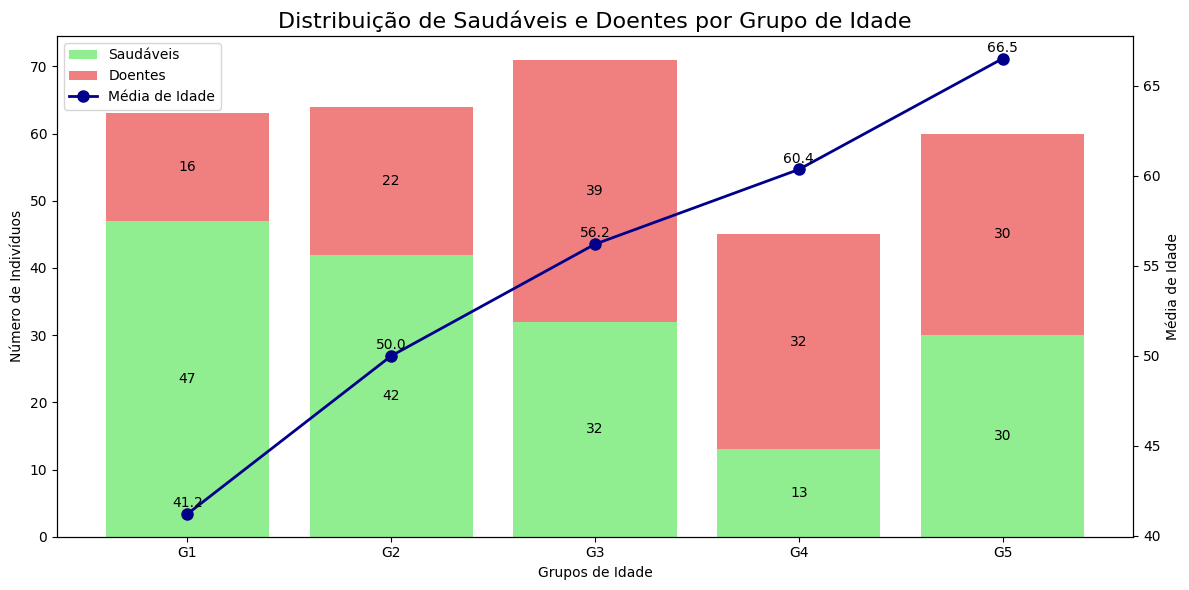

In [6]:
# Preparando os dados para o gráfico
bivariada_plot = bivariada_final[bivariada_final['age_group'] != 'Total'].copy()
bivariada_plot['saudaveis'] = bivariada_plot['saudaveis'].astype(int)
bivariada_plot['doentes'] = bivariada_plot['doentes'].astype(int)
bivariada_plot['age_mean'] = bivariada_plot['age_mean'].astype(float)

# Criando o gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras empilhadas
ax1.bar(bivariada_plot['age_group'], bivariada_plot['saudaveis'], label='Saudáveis', color='lightgreen')
ax1.bar(bivariada_plot['age_group'], bivariada_plot['doentes'], bottom=bivariada_plot['saudaveis'], label='Doentes', color='lightcoral')

# Configurando o eixo y primário
ax1.set_ylabel('Número de Indivíduos')
ax1.set_xlabel('Grupos de Idade')
ax1.tick_params(axis='y')

# Criando o eixo y secundário para a média de idade
ax2 = ax1.twinx()
ax2.plot(bivariada_plot['age_group'], bivariada_plot['age_mean'], color='darkblue', marker='o', linestyle='-', linewidth=2, markersize=8, label='Média de Idade')
ax2.set_ylabel('Média de Idade')
ax2.tick_params(axis='y')

# Adicionando rótulos nas barras
for i, (saudaveis, doentes) in enumerate(zip(bivariada_plot['saudaveis'], bivariada_plot['doentes'])):
    ax1.text(i, saudaveis/2, str(saudaveis), ha='center', va='center')
    ax1.text(i, saudaveis + doentes/2, str(doentes), ha='center', va='center')

# Adicionando rótulos na linha de média de idade
for i, (age_mean, y) in enumerate(zip(bivariada_plot['age_mean'], bivariada_plot['age_mean'])):
    ax2.annotate(f'{age_mean:.1f}', (i, y), xytext=(0, 5), textcoords='offset points', ha='center')

# Configurando a legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Configurando o título e ajustando o layout
plt.title('Distribuição de Saudáveis e Doentes por Grupo de Idade', fontsize=16)
plt.tight_layout()

# Exibindo o gráfico
plt.show()